In [58]:
import sys
import psycopg2
from psycopg2 import sql
from scipy import stats as kl
import pandas as pd
import numpy as np
from collections import defaultdict
from math import log,pi
from decimal import Decimal
import seaborn as sns
import builtins
import matplotlib.pyplot as plt
from scipy.stats import entropy as kl_divergence
from scipy.stats import entropy
%matplotlib inline

In [59]:
hostname = 'localhost'
username = 'postgres'
password = 'pass'
database = 'seedb'

continuous=['age','fnlwgt', 'education_num','capital_gain','capital_loss','hours_per_week']
discrete=['workclass','education','occupation','relationship','race','sex','native_country','income']
aggregate=['sum','avg','max','min','count']

k=10
num_partitions=20
delta= 0.01

In [60]:
connection = psycopg2.connect(host=hostName, user=userName, password=password, dbname=database)

In [61]:
def iterateRecords(data):
    return data.items() if isinstance(data, dict) else data.fetchall()


def aggregateValues(obj1, obj2):
    dictRes = defaultdict(lambda: [Decimal(1e-10), Decimal(1e-10)])

    for k, v in iterateRecords(obj1):
        v = v if v != 0 else Decimal(1e-10)
        dictRes[k][0] = v

    for k, v in iterateRecords(obj2):
        v = v if v != 0 else Decimal(1e-10)
        dictRes[k][1] = v

    list1, list2 = zip(*dictRes.values())

    return list(list1), list(list2)


In [62]:
def calculateNormalizedUtility(list1, list2):
    sum1 = max(sum(list1), Decimal(1e-10))
    sum2 = max(sum(list2), Decimal(1e-10))

    norm1 = [i / sum1 for i in list1]
    norm2 = [i / sum2 for i in list2]

    norm1 = [float(x) for x in norm1]
    norm2 = [float(x) for x in norm2]

    return entropy(norm1, norm2)


def getTopItems(dictKl, k):
    sortedItems = sorted(dictKl.items(), key=lambda item: item[1], reverse=True)
    return sortedItems[:min(k, len(sortedItems))]
    

In [63]:
dictKl = defaultdict(list)
views = []
for a in aggregate:
    for d in discrete:
        for c in continuous:
            views.append((d, c, a))

for d, c, a in views:
    q1 = 'select ' + d + ', ' + a + '(' + c + ') from married_adult where ' + d + ' is not null group by ' + d + ' order by ' + d + ';'
    q2 = 'select ' + d + ', ' + a + '(' + c + ') from unmarried_adult where ' + d + ' is not null group by ' + d + ' order by ' + d + ';'
    res1 = connection.cursor()
    res1.execute(q1)
    res2 = connection.cursor()
    res2.execute(q2)
    list1, list2 = aggregateValues(res1, res2)
    dictKl[d, c, a].append(calculateNormalizedUtility(list1, list2))


getTopItems(dictKl, k)


[(('relationship', 'fnlwgt', 'sum'), [39.314061097298094]),
 (('relationship', 'capital_gain', 'sum'), [37.04154672716982]),
 (('relationship', 'capital_loss', 'sum'), [34.45079346622531]),
 (('relationship', 'hours_per_week', 'sum'), [32.36904724966164]),
 (('relationship', 'age', 'sum'), [32.31235870533065]),
 (('relationship', 'education_num', 'sum'), [31.165882402680765]),
 (('relationship', 'age', 'count'), [28.752101209302545]),
 (('relationship', 'fnlwgt', 'count'), [28.752101209302545]),
 (('relationship', 'education_num', 'count'), [28.752101209302545]),
 (('relationship', 'capital_gain', 'count'), [28.752101209302545])]

In [64]:
def applyFunc(values, function):
    if function == 'count':
        function = 'sum'
    return getattr(builtins, function)(values)


def computeAverage(values, counts):
    totalWeighted = sum(v * c for v, c in zip(values, counts))
    totalCounts = sum(counts)
    return totalWeighted / totalCounts if totalCounts else Decimal(1e-10)

def mergeQueries():
    discreteList = ','.join(discrete)
    groupByClause = f' GROUP BY {discreteList}'

    whereClause = ' WHERE ' + ' AND '.join(f'{d} IS NOT NULL' for d in discrete)

    aggregateContinuous = ', '.join(
        f'{a}({c}) AS {a}_{c}' for a in aggregate for c in continuous
    )

    combinedQueries = [
        f'SELECT {discreteList}, {aggregateContinuous} FROM {tableName}_adult{whereClause}{groupByClause};'
        for tableName in ['married', 'unmarried']
    ]

    return combinedQueries

In [65]:
def evaluateDataFrames(dfList, views):
    dictKl = defaultdict(list)
    for d, c, a in views:
        attrList = [defaultdict(list), defaultdict(list)]
        for i, df in enumerate(dfList):
            for val in df[d].unique():
                filteredDf = df[df[d] == val]
                values = list(filteredDf[f"{a}_{c}"])
                if a == 'avg':
                    counts = list(filteredDf[f"count_{c}"])
                    result = computeAverage(values, counts)
                else:
                    result = applyFunc(values, a)
                attrList[i][val] = result
        list1, list2 = aggregateValues(attrList[0], attrList[1])
        dictKl[d, c, a].append(calculateNormalizedUtility(list1, list2))
    return dictKl


In [66]:
q1, q2 = mergeQueries()

res1 = connection.cursor()
res1.execute(q1)
res2 = connection.cursor()
res2.execute(q2)

dfRes1 = pd.DataFrame(res1.fetchall())
dfRes1.columns = [desc[0] for desc in res1.description]
dfRes2 = pd.DataFrame(res2.fetchall())
dfRes2.columns = [desc[0] for desc in res2.description]

dictKl = defaultdict(list)

dfList = [dfRes1, dfRes2]
dictKl = evaluateDataFrames(dfList, views)

getTopItems(dictKl, k)

[(('relationship', 'fnlwgt', 'sum'), [39.3140610972981]),
 (('relationship', 'capital_gain', 'sum'), [37.04154672716981]),
 (('relationship', 'capital_loss', 'sum'), [34.450793466225306]),
 (('relationship', 'hours_per_week', 'sum'), [32.36904724966164]),
 (('relationship', 'age', 'sum'), [32.31235870533064]),
 (('relationship', 'education_num', 'sum'), [31.16588240268076]),
 (('relationship', 'age', 'count'), [28.752101209302545]),
 (('relationship', 'fnlwgt', 'count'), [28.752101209302545]),
 (('relationship', 'education_num', 'count'), [28.752101209302545]),
 (('relationship', 'capital_gain', 'count'), [28.752101209302545])]

In [67]:
def calculateConfidence(m, N, delta):
    t1 = 1 - ((m - 1) / N)
    t2 = 2 * log(log(m))
    t3 = log(pi ** 2 / (3 * delta))
    numerator = t1 * t2 + t3
    denominator = 2 * m
    epsilonM = (numerator / denominator) ** 0.5
    return epsilonM


def updateStats(dictKl):
    dictStats = defaultdict(dict)
    for key, vals in dictKl.items():
        dictStats[key]['mean'] = sum(vals) / len(vals)
        CI = calculateConfidence(len(dictKl[key]), numPartitions, delta)
        dictStats[key]['lowerCI'] = dictStats[key]['mean'] - CI
        dictStats[key]['upperCI'] = dictStats[key]['mean'] + CI
    return dictStats


In [68]:
def updateStatsAndPruneViews(dictListKl, views, numPartitions, delta, k):
    dictStats = defaultdict(dict)
    lowerCIs = []

    for key, vals in dictListKl.items():
        mean = sum(vals) / len(vals)
        CI = calculateConfidence(len(vals), numPartitions, delta)
        lowerCI = mean - CI
        upperCI = mean + CI

        dictStats[key] = {'mean': mean, 'lowerCI': lowerCI, 'upperCI': upperCI}
        lowerCIs.append(lowerCI)

    lowerCIsSorted = sorted(lowerCIs, reverse=True)
    kLowestCI = lowerCIsSorted[k - 1] if len(lowerCIsSorted) >= k else -float('inf')

    for key, stats in dictStats.items():
        if stats['upperCI'] < kLowestCI:
            views.remove(key)
            del dictListKl[key]

    return dictStats


def computePartition(dfListPartitions, views, numPartitions, delta, k):
    dictListKl = defaultdict(list)

    for i, dfList in enumerate(dfListPartitions):
        partitionDictKl = evaluateDataFrames(dfList, views)

        for key, value in partitionDictKl.items():
            dictListKl[key].append(value[0])

        if i > 0:  # Avoid math domain error in the confidence function
            dictStats = updateStatsAndPruneViews(dictListKl, views, numPartitions, delta, k)

    dictKl = {key: stats['mean'] for key, stats in dictStats.items()}
    return dictKl


In [72]:
q1, q2 = mergeQueries()

res1 = connection.cursor()
res1.execute(q1)
res2 = connection.cursor()
res2.execute(q2)

dfRes1 = pd.DataFrame(res1.fetchall())
dfRes1.columns = [desc[0] for desc in res1.description]
dfRes2 = pd.DataFrame(res2.fetchall())
dfRes2.columns = [desc[0] for desc in res2.description]

dfRes1Partitions = np.array_split(dfRes1, numPartitions)
dfRes1Partitions = np.array_split(dfRes2, numPartitions)

dictListKl = defaultdict(list)
dictStats = defaultdict(dict)

dfListPartitions = [(dfRes1Partitions[i], dfRes2Partitions[i]) for i in range(numPartitions)]
dictKl = computePartition(dfListPartitions, views, numPartitions, delta, k)

getTopItems(dictKl, k)


[(('relationship', 'fnlwgt', 'sum'), 36.44340265851132),
 (('relationship', 'capital_gain', 'sum'), 33.76557663898073),
 (('relationship', 'capital_loss', 'sum'), 31.500006601095844),
 (('relationship', 'hours_per_week', 'sum'), 29.4670275717653),
 (('relationship', 'age', 'sum'), 29.432273782938818),
 (('relationship', 'education_num', 'sum'), 28.261205249237243),
 (('relationship', 'capital_gain', 'max'), 27.677467757266168),
 (('relationship', 'age', 'count'), 25.910892753874567),
 (('relationship', 'fnlwgt', 'count'), 25.910892753874567),
 (('relationship', 'education_num', 'count'), 25.910892753874567)]

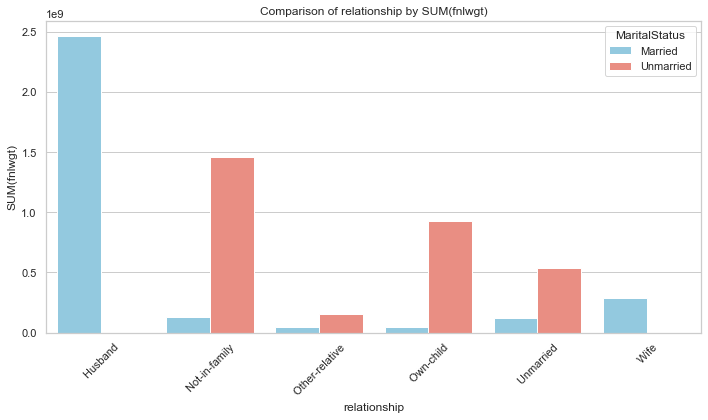

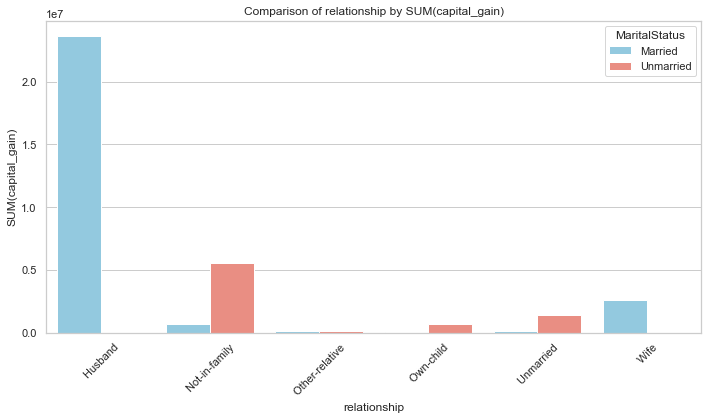

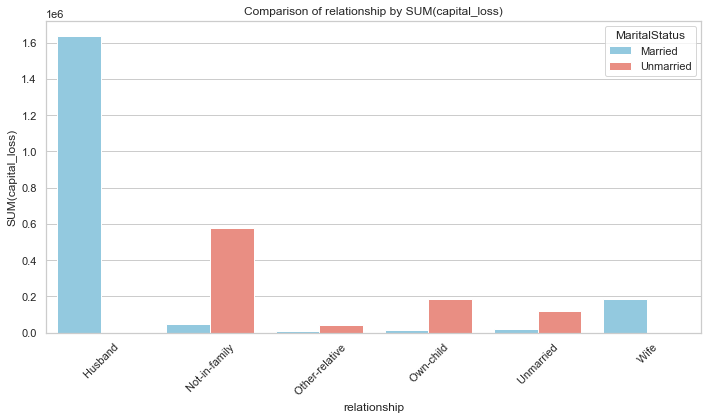

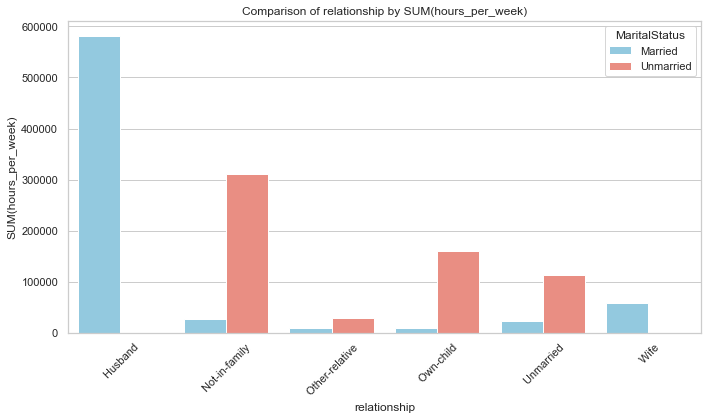

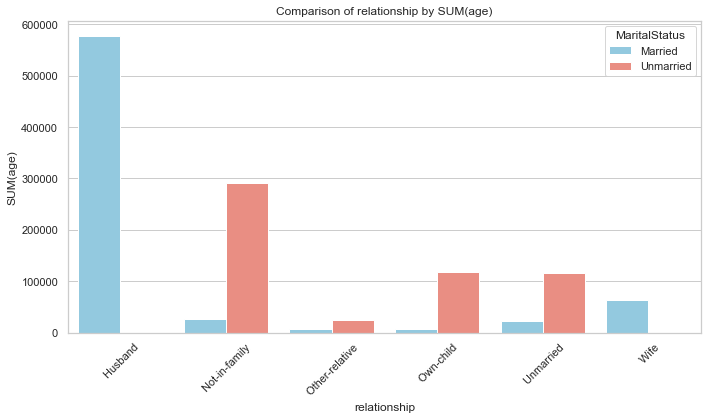

In [75]:
def visualizeQueries(queries):
    custom_colors = {"Married": "skyblue", "Unmarried": "salmon"}

    for a, m, f in queries:
        q1 = f'SELECT {a}, {f}({m}) FROM married_adult WHERE {a} IS NOT NULL GROUP BY {a} ORDER BY {a};'
        q2 = f'SELECT {a}, {f}({m}) FROM unmarried_adult WHERE {a} IS NOT NULL GROUP BY {a} ORDER BY {a};'

        res1 = connection.cursor()
        res1.execute(q1)
        res2 = connection.cursor()
        res2.execute(q2)

        df_res1 = pd.DataFrame(res1.fetchall(), columns=["relationship", f"valueMarried_{m}"])
        df_res2 = pd.DataFrame(res2.fetchall(), columns=["relationship", f"valueUnmarried_{m}"])

        mergedRes = pd.merge(df_res1, df_res2, on='relationship', how='outer').fillna(0)

        meltedMergedRes = mergedRes.melt(id_vars='relationship', var_name='MaritalStatus', value_name=f'{f.upper()}({m})')
        meltedMergedRes['MaritalStatus'] = meltedMergedRes['MaritalStatus'].map({
            f'valueMarried_{m}': 'Married',
            f'valueUnmarried_{m}': 'Unmarried'
        })

        plt.figure(figsize=(10, 6))
        sns.barplot(x='relationship', y=f'{f.upper()}({m})', hue='MaritalStatus', data=meltedMergedRes, palette=custom_colors)
        plt.title(f'Comparison of {a} by {f.upper()}({m})')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

top5Total = [
    (('relationship', 'fnlwgt', 'sum'), 36.44340265851132),
    (('relationship', 'capital_gain', 'sum'), 33.76557663898073),
    (('relationship', 'capital_loss', 'sum'), 31.500006601095844),
    (('relationship', 'hours_per_week', 'sum'), 29.4670275717653),
    (('relationship', 'age', 'sum'), 29.432273782938818)
]

queryParameters = [q[0] for q in top5Total]
visualizeQueries(queryParameters)
